 📈 Portfolio Optimization with Python

This notebook demonstrates how to build an optimized stock portfolio using historical data, Monte Carlo simulations, and performance metrics like the Sharpe Ratio and Value at Risk (VaR).

📌 **Goal:** Maximize return and minimize risk through optimal asset allocation.

 🧰 Tools & Techniques Used

- **Python** (NumPy, Pandas, Matplotlib)
- **Yahoo Finance API** for historical data
- **Monte Carlo simulation** to generate 10,000+ random portfolios
- **Sharpe Ratio** for risk-adjusted performance
- **Value at Risk (VaR)** for downside risk
- **Backtesting** to compare optimized portfolio vs S&P 500

 📅 Time Period

- Historical data from **June 2020 to June 2023**
- 5 selected stocks: `AAPL`, `GOOGL`, `AMZN`, `JPM`, `KO`

 📊 Final Output

- Optimal portfolio weights
- Sharpe-maximized portfolio
- Cumulative return curve
- Risk metrics including VaR


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
tickers = ['AAPL', 'GOOGL', 'AMZN', 'JPM', 'KO']

# Download only 'Close' prices to avoid shape errors
data = yf.download(tickers, start="2020-06-01", end="2023-06-01")['Close']
data = data.dropna()
data.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_532\3537947199.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-06-01", end="2023-06-01")['Close']
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,JPM,KO
Date,,,,,
2020-06-01,78.215126,123.552002,71.315788,85.798073,40.014393
2020-06-02,78.577209,123.620499,71.685577,86.085243,39.937759
2020-06-03,79.009766,123.919998,71.533485,90.731888,40.789307
2020-06-04,78.329323,123.029999,70.293419,92.620163,40.806335
2020-06-05,80.560219,124.150002,71.571754,96.788246,41.802650


In [3]:
np.random.seed(42)

mean_daily_returns = data.pct_change().mean()
cov_matrix = data.pct_change().cov()

num_portfolios = 10000
all_weights = []
returns_list = []
volatility_list = []
sharpe_list = []

for _ in range(num_portfolios):
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)

    all_weights.append(weights)

    port_return = np.sum(mean_daily_returns * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = port_return / port_volatility

    returns_list.append(port_return)
    volatility_list.append(port_volatility)
    sharpe_list.append(sharpe_ratio)

results_df = pd.DataFrame({
    'Return': returns_list,
    'Volatility': volatility_list,
    'Sharpe Ratio': sharpe_list,
    'Weights': all_weights
})

best_index = results_df['Sharpe Ratio'].idxmax()
best_portfolio = results_df.loc[best_index]


In [4]:
for stock, weight in zip(tickers, best_portfolio['Weights']):
    print(f"{stock}: {weight:.2%}")


AAPL: 47.81%
GOOGL: 0.46%
AMZN: 7.60%
JPM: 16.47%
KO: 27.66%


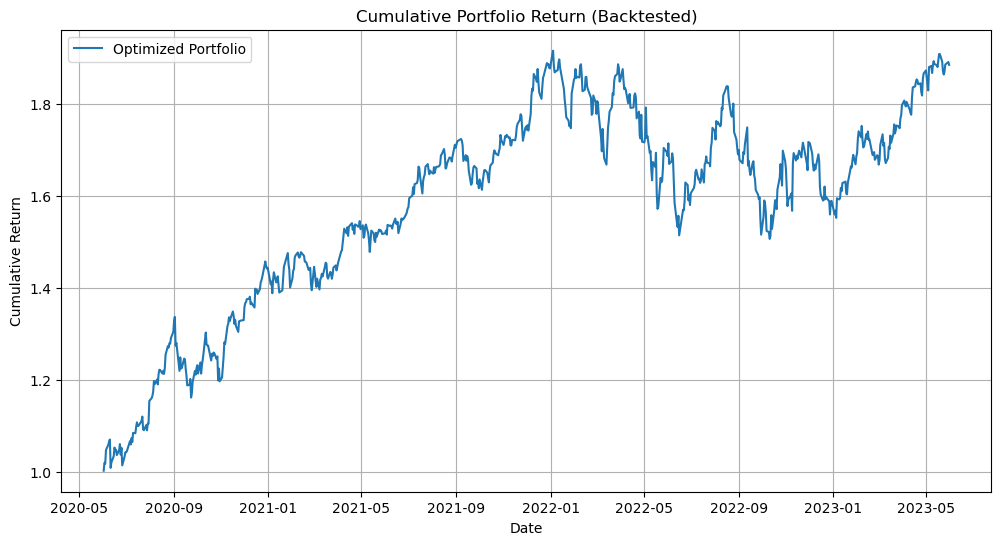

In [5]:
# Step 1: Calculate daily returns
returns = data.pct_change().dropna()

# Step 2: Apply weights to returns
weights = np.array(best_portfolio['Weights'])
weighted_returns = returns.mul(weights, axis=1)

# Step 3: Daily portfolio return
portfolio_returns = weighted_returns.sum(axis=1)

# Step 4: Cumulative portfolio return
cumulative_returns = (1 + portfolio_returns).cumprod()

# Step 5: Plot performance
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Cumulative Portfolio Return (Backtested)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


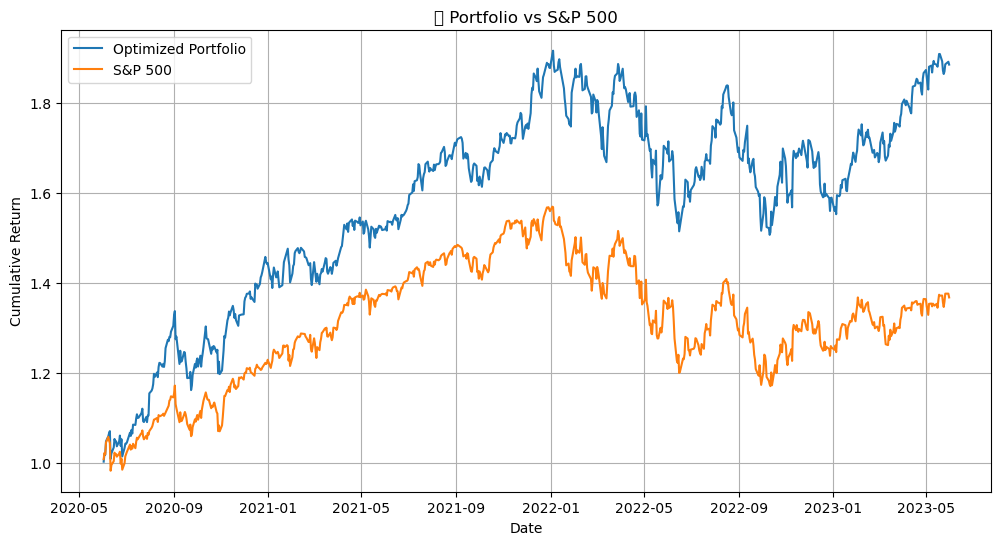

In [6]:
# Get S&P 500 data
benchmark = yf.download('^GSPC', start="2020-06-01", end="2023-06-01", auto_adjust=True)['Close']
benchmark_returns = benchmark.pct_change().dropna()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Plot both
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.plot(benchmark_cum_returns, label='S&P 500')
plt.title('📊 Portfolio vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Calculate 5% historical VaR
var_95 = np.percentile(portfolio_returns, 5)

print(f"📉 Value at Risk (95% confidence): {var_95:.2%}")


📉 Value at Risk (95% confidence): -2.04%


In [8]:
from scipy.stats import norm

# Calculate mean and std deviation of daily portfolio returns
mean_return = portfolio_returns.mean()
std_dev = portfolio_returns.std()

# 1-day 95% Value at Risk
var_95 = norm.ppf(0.05, mean_return, std_dev)
var_10day = var_95 * np.sqrt(10)

print(f"🔻 1-Day VaR (95% confidence): {var_95:.2%}")
print(f"🔻 10-Day VaR (95% confidence): {var_10day:.2%}")

🔻 1-Day VaR (95% confidence): -2.14%
🔻 10-Day VaR (95% confidence): -6.78%
